In [1]:
using Crystalline, MPBUtils, JLD2, LinearAlgebra, StaticArrays, SymmetryBases, PyPlot, DelimitedFiles, PrettyTables

In [74]:
using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/gridsan/aligho/.local/lib/python3.8/site-packages/numpy/__init__.py'>

In [2]:
include("./symeigs/corner_charges.jl")

polarization_sg12 (generic function with 2 methods)

In [79]:
# First we create the k mesh

ks = Vector{Vector{Float64}}()
N = 50
open("nodal_points/kpoints.sh", "w") do io 
    write(io, "kvecs=(list ")
    for i in 1:N
    for j in 1:N
        kx = (i-1)/N - 0.5
        ky = (j-1)/N - 0.5
        write(io, "(vector3 $(kx) $(ky)) ")
        push!(ks, [kx, ky])
    end
    end
    write(io, ")")
end

1

In [3]:
JLD2_DATA = Dict{Tuple{Integer, Integer, String}, Dict{String, Any}}()
sg = 10
for mode in ["te", "tm"]
    println("Analyzing mode: $mode\n")
    flush(stdout)
    for id_eps in 1:3
        println("Analyzing id_eps : ", id_eps)
        flush(stdout)
        dir = "./symeigs/output/sg$(sg)/eps$(id_eps)/$(mode)/"
        filename = dir*"sg$(sg)-epsid$(id_eps)-res64-$(mode).jld2"
        loaded_data = load(filename)
        JLD2_DATA[(sg, id_eps, mode)] = loaded_data
    end
end


Analyzing mode: te

Analyzing id_eps : 1
Analyzing id_eps : 2
Analyzing id_eps : 3
Analyzing mode: tm

Analyzing id_eps : 1
Analyzing id_eps : 2
Analyzing id_eps : 3


In [103]:
cumsummariesv = JLD2_DATA[10, 3, "tm"]["cumsummariesv"];

In [105]:
cumsummariesv[9588]

23-element Vector{BandSummary}:
 1-band (nontrivial): [X₁, M₂, Γ₁]
 2-band (trivial): [X₁+X₂, M₁+M₂, 2Γ₁]
 4-band (trivial): [X₁+3X₂, M₁+M₂+M₃M₄, 2Γ₁+Γ₃Γ₄]
 5-band (trivial): [2X₁+3X₂, M₁+2M₂+M₃M₄, 2Γ₁+Γ₂+Γ₃Γ₄]
 7-band (trivial): [3X₁+4X₂, M₁+2M₂+2M₃M₄, 3Γ₁+2Γ₂+Γ₃Γ₄]
 10-band (nontrivial): [5X₁+5X₂, 2M₁+2M₂+3M₃M₄, 4Γ₁+2Γ₂+2Γ₃Γ₄]
 12-band (nontrivial): [6X₁+6X₂, 3M₁+3M₂+3M₃M₄, 4Γ₁+2Γ₂+3Γ₃Γ₄]
 15-band (trivial): [8X₁+7X₂, 3M₁+4M₂+4M₃M₄, 4Γ₁+3Γ₂+4Γ₃Γ₄]
 16-band (trivial): [8X₁+8X₂, 4M₁+4M₂+4M₃M₄, 4Γ₁+4Γ₂+4Γ₃Γ₄]
 18-band (trivial): [9X₁+9X₂, 4M₁+4M₂+5M₃M₄, 5Γ₁+5Γ₂+4Γ₃Γ₄]
 20-band (trivial): [10X₁+10X₂, 5M₁+5M₂+5M₃M₄, 5Γ₁+5Γ₂+5Γ₃Γ₄]
 21-band (trivial): [10X₁+11X₂, 5M₁+6M₂+5M₃M₄, 6Γ₁+5Γ₂+5Γ₃Γ₄]
 24-band (trivial): [12X₁+12X₂, 6M₁+6M₂+6M₃M₄, 6Γ₁+6Γ₂+6Γ₃Γ₄]
 25-band (nontrivial): [12X₁+13X₂, 7M₁+6M₂+6M₃M₄, 7Γ₁+6Γ₂+6Γ₃Γ₄]
 26-band (nontrivial): [13X₁+13X₂, 7M₁+7M₂+6M₃M₄, 7Γ₁+7Γ₂+6Γ₃Γ₄]
 28-band (trivial): [14X₁+14X₂, 7M₁+7M₂+7M₃M₄, 7Γ₁+7Γ₂+7Γ₃Γ₄]
 30-band (nontrivial): [14X₁+16X₂, 8M₁+8M₂+7M₃M₄

In [68]:
# Below we find candidates that are topological and without corner charge or polarization

In [69]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    
    band_summary = cumsummary[1]
    #first_band_corner = corners(band_summary, wyckoffs(10, 2)[end])
    #first_band_polarization = polarizations(band_summary, wyckoffs(10, 2)[end])

    band_summary.topology == NONTRIVIAL || continue
    band_summary.n[end] < 2 || continue

    push!(usable_ids, i)
    #(first_band_corner ≈ 0 && first_band_polarization ≈ zeros(2)) && push!(usable_ids, i)
end

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [70]:
usable_ids

14-element Vector{Int64}:
  392
  742
  795
 1512
 1931
 2164
 2536
 3747
 4106
 4544
 5162
 5718
 7986
 9588

In [65]:
cumsummariesv[usable_ids[end]]

23-element Vector{BandSummary}:
 1-band (nontrivial): [X₁, M₂, Γ₁]
 2-band (trivial): [X₁+X₂, M₁+M₂, 2Γ₁]
 4-band (trivial): [X₁+3X₂, M₁+M₂+M₃M₄, 2Γ₁+Γ₃Γ₄]
 5-band (trivial): [2X₁+3X₂, M₁+2M₂+M₃M₄, 2Γ₁+Γ₂+Γ₃Γ₄]
 7-band (trivial): [3X₁+4X₂, M₁+2M₂+2M₃M₄, 3Γ₁+2Γ₂+Γ₃Γ₄]
 10-band (nontrivial): [5X₁+5X₂, 2M₁+2M₂+3M₃M₄, 4Γ₁+2Γ₂+2Γ₃Γ₄]
 12-band (nontrivial): [6X₁+6X₂, 3M₁+3M₂+3M₃M₄, 4Γ₁+2Γ₂+3Γ₃Γ₄]
 15-band (trivial): [8X₁+7X₂, 3M₁+4M₂+4M₃M₄, 4Γ₁+3Γ₂+4Γ₃Γ₄]
 16-band (trivial): [8X₁+8X₂, 4M₁+4M₂+4M₃M₄, 4Γ₁+4Γ₂+4Γ₃Γ₄]
 18-band (trivial): [9X₁+9X₂, 4M₁+4M₂+5M₃M₄, 5Γ₁+5Γ₂+4Γ₃Γ₄]
 20-band (trivial): [10X₁+10X₂, 5M₁+5M₂+5M₃M₄, 5Γ₁+5Γ₂+5Γ₃Γ₄]
 21-band (trivial): [10X₁+11X₂, 5M₁+6M₂+5M₃M₄, 6Γ₁+5Γ₂+5Γ₃Γ₄]
 24-band (trivial): [12X₁+12X₂, 6M₁+6M₂+6M₃M₄, 6Γ₁+6Γ₂+6Γ₃Γ₄]
 25-band (nontrivial): [12X₁+13X₂, 7M₁+6M₂+6M₃M₄, 7Γ₁+6Γ₂+6Γ₃Γ₄]
 26-band (nontrivial): [13X₁+13X₂, 7M₁+7M₂+6M₃M₄, 7Γ₁+7Γ₂+6Γ₃Γ₄]
 28-band (trivial): [14X₁+14X₂, 7M₁+7M₂+7M₃M₄, 7Γ₁+7Γ₂+7Γ₃Γ₄]
 30-band (nontrivial): [14X₁+16X₂, 8M₁+8M₂+7M₃M₄

In [114]:
bands = readdlm("./nodal_points/output/dim2-sg10-29588-res64-tm-dispersion.out", ',')[:, 6:end]
bands1 = bands[:, 1]
bands2 = bands[:, 2]
bands1_reshaped = reshape(bands1, (50, 50))
bands2_reshaped = reshape(bands2, (50, 50));

In [115]:
# Find the nodal points:
ks[sortperm(bands2 - bands1)][1:4]

4-element Vector{Vector{Float64}}:
 [-0.5, -0.48]
 [-0.5, 0.48]
 [-0.48, -0.5]
 [0.48, -0.5]

In [116]:
sort(bands2-bands1)

2500-element Vector{Float64}:
 7.999999999980245e-6
 7.999999999980245e-6
 7.999999999980245e-6
 7.999999999980245e-6
 8.999999999981245e-6
 2.2999999999995246e-5
 2.2999999999995246e-5
 2.2999999999995246e-5
 2.2999999999995246e-5
 3.600000000000825e-5
 3.600000000000825e-5
 3.600000000000825e-5
 3.600000000000825e-5
 ⋮
 0.258465
 0.258465
 0.258465
 0.26518548999999997
 0.26518548999999997
 0.2651855
 0.2651855
 0.26860441
 0.26860442
 0.26860442
 0.26860442
 0.2765

In [112]:
[0 1; -1 0 ]^2*[-0.5, -0.48]

2-element Vector{Float64}:
 0.5
 0.48

In [83]:
ks[argmin(bands2-bands1)]

2-element Vector{Float64}:
 -0.5
 -0.48

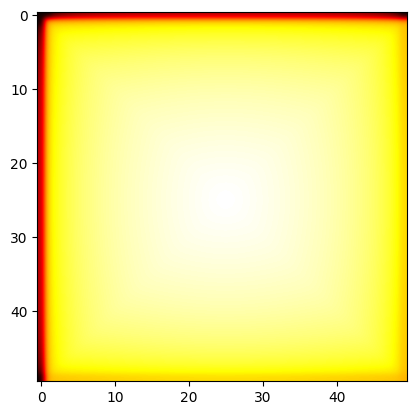

PyObject <matplotlib.image.AxesImage object at 0x7f76535a3490>

In [108]:
imshow(log.(np.roll(bands2_reshaped - bands1_reshaped, (0,0), axis=(0, 1))), cmap="hot", interpolation="gaussian")


In [97]:
bands = readdlm("./nodal_points/output/dim2-sg10-20004-res64-te-dispersion.out", ',')[:, 6:end]
bands1 = bands[:, 1]
bands2 = bands[:, 2]
bands1_reshaped = reshape(bands1, (50, 50))
bands2_reshaped = reshape(bands2, (50, 50));

In [109]:
ks[sortperm(bands2 - bands1)][1:4]

4-element Vector{Vector{Float64}}:
 [-0.5, -0.48]
 [-0.5, 0.48]
 [-0.48, -0.5]
 [0.48, -0.5]

In [ ]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end])

    cumsummariesv[1][1].topology == TRIVIAL || continue
    (cumsummary[1].n)[end] < 2 || continue
    (first_band_corner != 0 && first_band_polarization ≈ zeros(2)) && push!(usable_ids, i)
end

In [184]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end])

    cumsummariesv[1][1].topology == TRIVIAL || continue
    (cumsummary[1].n)[end] < 2 || continue
    (first_band_corner != 0 && first_band_polarization ≈ zeros(2)) && push!(usable_ids, i)
end

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [168]:
usable_ids

1518-element Vector{Int64}:
    1
    4
   10
   28
   29
   30
   33
   34
   36
   44
   46
   55
   58
    ⋮
 9914
 9915
 9917
 9928
 9936
 9950
 9953
 9969
 9975
 9980
 9981
 9985

In [167]:
[x[1] for x in cumsummariesv[usable_ids]]

1518-element Vector{BandSummary}:
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 ⋮
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]

In [134]:
for id in usable_ids
    real_id = id + Int(2e4)
    band_data = readdlm("./symeigs/output/sg10/eps3/tm/dim2-sg10-$(real_id)-res64-tm-dispersion.out", ',')[:, 6:end]
    band1_data = band_data[:, 1]
    band2_data = band_data[:, 2]
    println((maximum(band1_data) - minimum(band2_data))/maximum(band1_data))
end

0.2670788607129
0.17807031169100135
0.2576058310192497
0.2526397103198552
0.27734646956915954
0.2495727097241213
0.24854129636212813
0.23965094785711213
0.2736164570841343
0.26052337046314544
0.2349363570712274
0.2638101173316356
0.17145876862222573
0.2715724989874443
0.2805076798868703
0.2501144325904017
0.2584139150749928
0.2462506086674241
0.2869301915309581
0.2826271676445893


In [121]:
.05/.2

0.25

In [105]:
lgirreps(10, 2)

Dict{String, Vector{LGIrrep{2}}} with 4 entries:
  "X" => [LGIrrep{2}("X₁", [1, 2] ([0, 1/2]), Matrix{ComplexF64}[[1.0+0…
  "M" => [LGIrrep{2}("M₁", [1, 2, 4⁺, 4⁻] ([1/2, 1/2]), Matrix{ComplexF…
  "Γ" => [LGIrrep{2}("Γ₁", [1, 2, 4⁺, 4⁻] ([0, 0]), Matrix{ComplexF64}[…
  "Ω" => [LGIrrep{2}("Ω₁", [1] ([α, β]), Matrix{ComplexF64}[[1.0+0.0im;…

In [135]:
usable_ids .+ 20000

20-element Vector{Int64}:
 20654
 20795
 22164
 22391
 22415
 22585
 22724
 22885
 23265
 23572
 24247
 24543
 25718
 26299
 26702
 27057
 27986
 28090
 28798
 29588

In [90]:
usable_ids_no_corner = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end])

    cumsummariesv[1][1].topology == TRIVIAL || continue
    (cumsummariesv[1][1].n)[end] < 2 || continue
    (first_band_corner ≈ 0 && first_band_polarization ≈ zeros(2)) && push!(usable_ids_no_corner, i)
end

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [91]:
usable_ids_no_corner

4121-element Vector{Int64}:
    6
    7
    9
   11
   13
   15
   17
   18
   19
   20
   24
   38
   39
    ⋮
 9973
 9976
 9982
 9983
 9984
 9986
 9988
 9990
 9992
 9994
 9997
 9998

In [40]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end-1])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end-1])
    i % 1000 == 0 && println(first_band_corner)
    i % 1000 == 0 && println(first_band_polarization)

    (first_band_corner != 0 && first_band_polarization == 0) && push!(usable_ids, i)
end

Iteration: 1000
0.0
[0.5, 0.5]
Iteration: 2000
0.0
[0.0, 0.0]
Iteration: 3000
0.25
[0.5, 0.5]
Iteration: 4000
0.0
[0.5, 0.5]
Iteration: 5000
0.25
[0.5, 0.5]
Iteration: 6000
0.0
[0.5, 0.5]
Iteration: 7000
0.25
[0.5, 0.5]
Iteration: 8000
0.25
[0.5, 0.5]
Iteration: 9000
0.25
[0.5, 0.5]
Iteration: 10000
0.0
[0.5, 0.5]


1

In [170]:
bands = readdlm("./nodal_points/output/dim2-sg10-28798-res64-tm-dispersion.out", ',')[:, 6:end]
bands1_reshaped = reshape(bands[:, 1], (30, 30))
bands2_reshaped = reshape(bands[:, 2], (30, 30))

30×30 Matrix{Float64}:
 0.193859  0.188463  0.182435  0.176634  …  0.176634  0.182435  0.188463
 0.188463  0.194285  0.189277  0.183718     0.183727  0.189286  0.194285
 0.182435  0.189286  0.195558  0.191027     0.191041  0.195558  0.189277
 0.176634  0.183727  0.191041  0.197662     0.197662  0.191027  0.183718
 0.171108  0.17843   0.185987  0.193641     0.19362   0.185973  0.178422
 0.16589   0.173441  0.181221  0.189102  …  0.189083  0.181209  0.173433
 0.161016  0.168792  0.176788  0.184874     0.184857  0.176777  0.168785
 0.15652   0.164515  0.172719  0.180997     0.180982  0.172709  0.164509
 0.152438  0.160644  0.169042  0.1775       0.177488  0.169034  0.160638
 0.148807  0.157208  0.165787  0.17441      0.174399  0.16578   0.157203
 0.145661  0.154239  0.162979  0.171749  …  0.17174   0.162974  0.154235
 0.143033  0.151765  0.160644  0.169539     0.169532  0.16064   0.151762
 0.140955  0.149811  0.158803  0.167799     0.167794  0.1588    0.149809
 ⋮                          

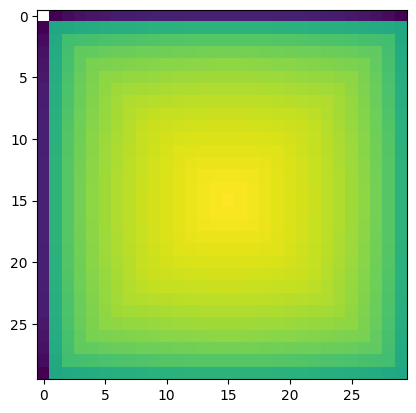

PyObject <matplotlib.image.AxesImage object at 0x7fd9973b6bb0>

In [174]:
imshow(log.(bands2_reshaped .- bands1_reshaped))

In [99]:
bands = readdlm("./nodal_points/output/dim2-sg10-20004-res64-te-dispersion.out", ',')[:, 6:end]
bands1_reshaped = reshape(bands[:, 1], (50, 50))
bands2_reshaped = reshape(bands[:, 2], (50, 50))

50×50 Matrix{Float64}:
 0.481494  0.479485  0.474076  0.466446  …  0.466457  0.474087  0.479497
 0.479485  0.47764   0.47247   0.465096     0.465299  0.472583  0.477644
 0.474076  0.472577  0.468124  0.461502     0.461691  0.468128  0.472474
 0.466446  0.465291  0.461687  0.456095     0.456098  0.461506  0.4651
 0.457542  0.456691  0.453885  0.449391     0.449146  0.453528  0.456428
 0.447943  0.447364  0.445289  0.441878  …  0.441381  0.444776  0.447037
 0.437994  0.437672  0.436297  0.433956     0.433222  0.435639  0.437284
 0.427907  0.427852  0.427193  0.425948     0.424993  0.426394  0.427397
 0.417824  0.418075  0.418207  0.418122     0.416961  0.417262  0.417543
 0.407852  0.408487  0.409547  0.41071      0.409367  0.408449  0.407858
 0.398073  0.399241  0.401433  0.403907  …  0.402418  0.400178  0.398485
 0.388558  0.390541  0.394096  0.397855     0.396273  0.392699  0.389611
 0.379376  0.382712  0.387745  0.392615     0.391007  0.386262  0.381564
 ⋮                            

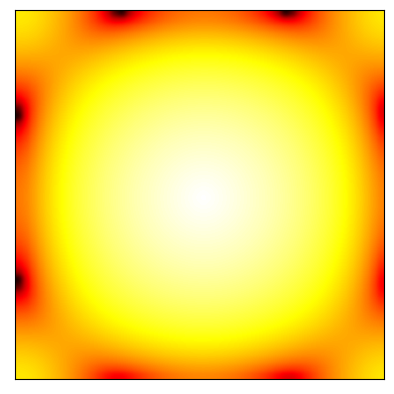

(Any[], Any[])

In [100]:
imshow(log.(np.roll(bands2_reshaped - bands1_reshaped, (0,0), axis=(0, 1))), cmap="hot", interpolation="gaussian")
xticks(Float64[])
yticks(Float64[])

In [197]:
using PyCall; np = pyimport("numpy")

PyObject <module 'numpy' from '/home/gridsan/aligho/.local/lib/python3.8/site-packages/numpy/__init__.py'>